In [1]:
!pip install opencv-python

In [2]:
!pip install numpy

In [3]:
!pip install ultralytics

In [4]:
from pathlib import Path
from ultralytics import YOLO
import matplotlib.pyplot as plt 
import cv2
import json
import numpy as np

In [5]:

# Definição do caminho para a imagem e qual modelo será utilizado
CAMINHO_IMAGEM = Path("Imagens/2013-03-20/2013-03-20_14_05_09.jpg")
MODELO_YOLO = "yolov8n.pt"

# Define o caminho de saída da imagem com as vagas
pasta_saida = Path("Saida/Imagens")
pasta_saida.mkdir(parents=True, exist_ok=True)

# Define um caminho de saída para o JSON de vagas
pasta_saida_JSON = Path("Saida/Vagas")
pasta_saida_JSON.mkdir(parents=True, exist_ok=True)
CAMINHO_VAGAS_JSON = pasta_saida_JSON / f"{CAMINHO_IMAGEM.stem}.JSON"

print(f"Usando imagem: {CAMINHO_IMAGEM}")
print(f"Salvando vagas em: {CAMINHO_VAGAS_JSON}")

Usando imagem: Imagens\2013-03-20\2013-03-20_14_05_09.jpg
Salvando vagas em: Saida\Vagas\2013-03-20_14_05_09.JSON


Carregando modelo yolov8n.pt...
Processando 2013-03-20_14_05_09.jpg...


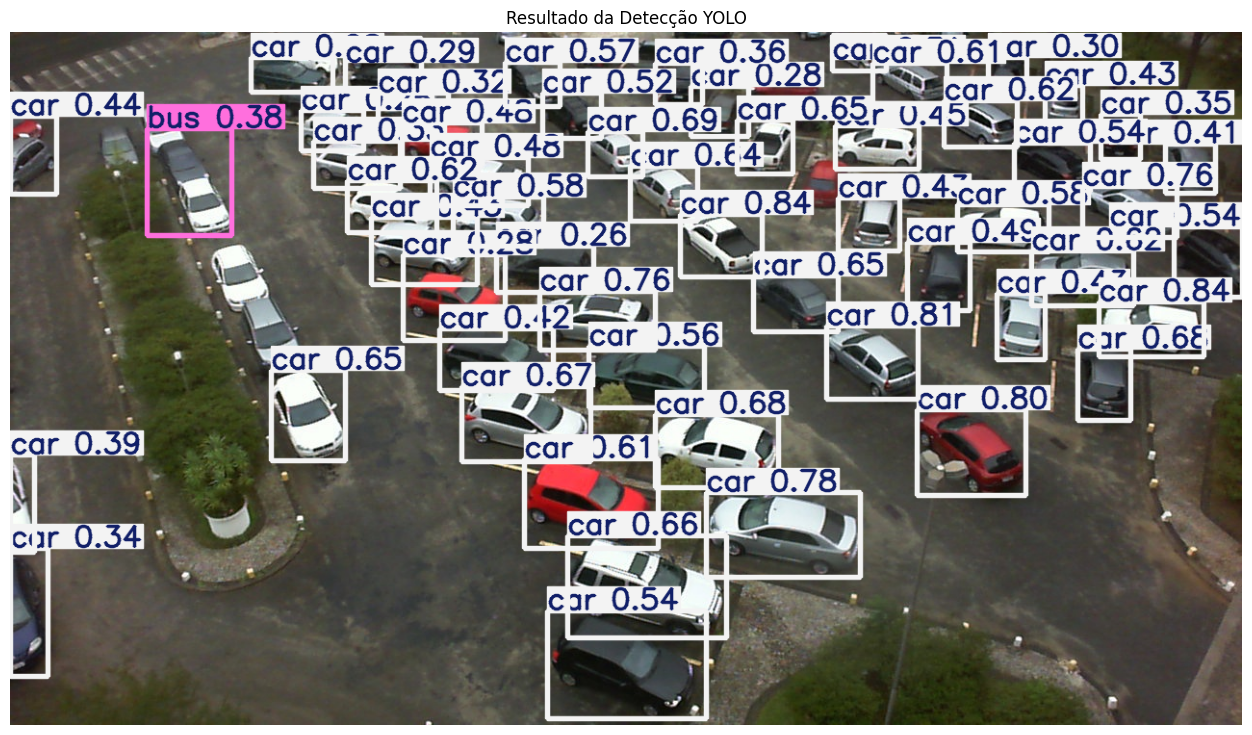

In [6]:

print(f"Carregando modelo {MODELO_YOLO}...")
# Carrega um modelo YOLO pré-treinado
modelo = YOLO(MODELO_YOLO)

print(f"Processando {CAMINHO_IMAGEM.name}...")
# Executa a detecção na imagem
resultado = modelo(CAMINHO_IMAGEM, verbose=False) # verbose=False para silenciar o log

# Mostra a imagem com as detecções
if resultado:
    # Obtem a imagem com as detecções (formato BGR)
    img_detectada_bgr = resultado[0].plot()
    
    # Converte de BGR para RGB (OpenCV -> Matplotlib)
    img_detectada_rgb = img_detectada_bgr[..., ::-1]

    # Mostrar a imagem inline no Jupyter
    plt.figure(figsize=(16, 9)) # Define um bom tamanho para a imagem
    plt.imshow(img_detectada_rgb)
    plt.axis('off') # Esconde os eixos X e Y
    plt.title("Resultado da Detecção YOLO")
    plt.show()
    

In [7]:

# Descrição dos comandos no topo superior esquerdo da imagem
NOME_JANELA = "Marcar Vagas - Pressione 's' para Salvar, 'u' para Desfazer, 'esc' para Sair"
COR_RASCUNHO = (0, 0, 255)  # Vermelho (BGR)
COR_VAGA_SALVA = (0, 255, 0) # Verde (BGR)
COR_TEXTO = (255, 255, 255) # Branco (BGR)

# Variáveis Globais para o Callback
vagas = []
drawing = False
x1_draw, y1_draw = 0, 0
img = None
orig = None

def desenhar_vaga(event, x, y, flags, param):
    # Callback do mouse para desenhar retângulos.
    global x1_draw, y1_draw, drawing, img

    if event == cv2.EVENT_LBUTTONDOWN:
        drawing = True
        x1_draw, y1_draw = x, y

    elif event == cv2.EVENT_MOUSEMOVE:
        if drawing:
            # Recria a imagem a partir da original + vagas salvas
            # para mostrar o rascunho sem sobrepor desenhos antigos
            img = orig.copy()
            for (x1, y1, x2, y2) in vagas:
                cv2.rectangle(img, (x1, y1), (x2, y2), COR_VAGA_SALVA, 2)
            
            # Desenha o rascunho
            cv2.rectangle(img, (x1_draw, y1_draw), (x, y), COR_RASCUNHO, 2)

    elif event == cv2.EVENT_LBUTTONUP:
        drawing = False
        x2_draw, y2_draw = x, y

        # Salva a vaga (garante que x1 < x2 e y1 < y2)
        vaga_coords = (
            min(x1_draw, x2_draw), 
            min(y1_draw, y2_draw), 
            max(x1_draw, x2_draw), 
            max(y1_draw, y2_draw)
        )
        vagas.append(vaga_coords)

        # Desenha o retângulo final (verde) na imagem principal
        cv2.rectangle(img, (vaga_coords[0], vaga_coords[1]), (vaga_coords[2], vaga_coords[3]), COR_VAGA_SALVA, 2)
        print(f"Vaga marcada: {vaga_coords}")

def desenhar_tudo():
    # Redesenha todas as vagas salvas (usado pelo 'Desfazer').
    global img
    img = orig.copy()
    for (x1, y1, x2, y2) in vagas:
        cv2.rectangle(img, (x1, y1), (x2, y2), COR_VAGA_SALVA, 2)

# Início do Script
img = cv2.imread(str(CAMINHO_IMAGEM))

if img is None:
    print(f"Erro: Não foi possível carregar a imagem em {CAMINHO_IMAGEM}")
else:
    orig = img.copy()
    cv2.namedWindow(NOME_JANELA)
    cv2.setMouseCallback(NOME_JANELA, desenhar_vaga)

    print("Arraste para marcar vaga. Pressione 's' para salvar, 'u' para desfazer, 'esc' para sair.")

    while True:
        # Cria uma cópia temporária para exibir o texto de ajuda
        img_com_texto = img.copy()
        
        # Adiciona o texto de ajuda na imagem
        cv2.putText(
            img_com_texto, 
            "'s' Salvar | 'u' Desfazer | 'esc' Sair", 
            (10, 30), # Posição (x, y)
            cv2.FONT_HERSHEY_SIMPLEX, 
            0.7, # Tamanho da fonte
            COR_TEXTO, 
            2 # Espessura
        )
        
        cv2.imshow(NOME_JANELA, img_com_texto)
        key = cv2.waitKey(1) & 0xFF

        # tecla S = Salvar
        if key == ord("s"):
            with open(CAMINHO_VAGAS_JSON, "w") as f:
                json.dump(vagas, f, indent=4)
            print(f"\nVagas salvas em {CAMINHO_VAGAS_JSON}")
            break

        # tecla U = Desfazer (Undo)
        elif key == ord("u"):
            if vagas:
                vaga_removida = vagas.pop()
                print(f"Vaga removida: {vaga_removida}")
                desenhar_tudo() # Redesenha a imagem sem a última vaga
            else:
                print("Nenhuma vaga para desfazer.")

        # tecla ESC = sair sem salvar
        elif key == 27:
            print("\nSaindo sem salvar.")
            break

    cv2.destroyAllWindows()
    

Arraste para marcar vaga. Pressione 's' para salvar, 'u' para desfazer, 'esc' para sair.
Vaga marcada: (1039, 503, 1169, 573)
Vaga marcada: (758, 493, 869, 536)
Vaga marcada: (686, 413, 803, 440)
Vaga marcada: (477, 378, 585, 422)
Vaga marcada: (548, 462, 649, 503)

Vagas salvas em Saida\Vagas\2013-03-20_14_05_09.JSON


In [8]:

try:
    with open(CAMINHO_VAGAS_JSON, "r") as f:
        vagas_lidas = json.load(f)
        print(f"Sucesso! {len(vagas_lidas)} vagas lidas de {CAMINHO_VAGAS_JSON}:")
        print(vagas_lidas)
except FileNotFoundError:
    print(f"Arquivo {CAMINHO_VAGAS_JSON} não encontrado.")
except Exception as e:
    print(f"Ocorreu um erro ao ler o arquivo: {e}")
    

Sucesso! 5 vagas lidas de Saida\Vagas\2013-03-20_14_05_09.JSON:
[[1039, 503, 1169, 573], [758, 493, 869, 536], [686, 413, 803, 440], [477, 378, 585, 422], [548, 462, 649, 503]]


In [ ]:


# Cores (em BGR)
COR_LIVRE = (0, 255, 0)   # Verde
COR_OCUPADA = (0, 0, 255) # Vermelho
COR_TEXTO = (255, 255, 255) # Branco

# Limite de Sobreposição (IoU): 
# Se um carro cobrir 20% da vaga, já conta como ocupada.
IOU_THRESHOLD = 0.2 

# FUNÇÃO DE INTERSEÇÃO (IoU) 
def calcular_iou(boxA, boxB):
    # Calcula a Interseção sobre União (IoU) entre duas caixas.
    # (x1, y1, x2, y2)
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # Área da interseção
    interArea = max(0, xB - xA) * max(0, yB - yA)
    if interArea == 0:
        return 0

    # Área de cada caixa
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])

    # IoU = Interseção / União (Área Vaga + Área Carro - Interseção)
    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou


# Carregar a imagem original
img = cv2.imread(str(CAMINHO_IMAGEM))
if img is None:
    print(f"Erro: Não foi possível carregar a imagem em {CAMINHO_IMAGEM}")
    # Encerra aqui se a imagem falhar
else:
    # Carregar as vagas salvas
    try:
        with open(CAMINHO_VAGAS_JSON, "r") as f:
            vagas = json.load(f)
        print(f"Carregadas {len(vagas)} vagas de {CAMINHO_VAGAS_JSON}")
    except FileNotFoundError:
        print(f"Erro: Arquivo {CAMINHO_VAGAS_JSON} não encontrado. Execute a Célula 56 primeiro.")
        # Encerra aqui se o JSON falhar
    else:
        # Carregar o modelo YOLO
        modelo = YOLO(MODELO_YOLO)

        # Rodar a detecção na imagem
        resultados = modelo(img, verbose=False) # verbose=False para silenciar o log

        # Coletar caixas de detecção (carros, ônibus, caminhões)
        deteccoes = []
        # IDs de classe: 2=carro, 5=ônibus, 7=caminhão
        classes_veiculos = [2, 5, 7] 
        
        if resultados[0].boxes is not None:
            for box in resultados[0].boxes:
                if int(box.cls[0]) in classes_veiculos:
                    # Converte para inteiros
                    coords = box.xyxy[0].cpu().numpy().astype(int)
                    deteccoes.append(coords)
        
        print(f"Detectados {len(deteccoes)} veículos (carros/ônibus/caminhões).")

        # VERIFICAR CADA VAGA 
        total_ocupadas = 0
        img_final = img.copy() # Cria cópia para desenhar

        for vaga in vagas:
            (x1_vaga, y1_vaga, x2_vaga, y2_vaga) = vaga
            status_vaga = "Livre"
            cor_final = COR_LIVRE

            for detec in deteccoes:
                iou = calcular_iou(vaga, detec)
                
                if iou > IOU_THRESHOLD:
                    status_vaga = "Ocupada"
                    cor_final = COR_OCUPADA
                    total_ocupadas += 1
                    break # Vaga ocupada, não precisa checar outros carros

            # Desenhar a vaga na imagem final
            cv2.rectangle(img_final, (x1_vaga, y1_vaga), (x2_vaga, y2_vaga), cor_final, 2)

        # MOSTRAR RESULTADO
        # Adicionar texto de resumo
        texto_status = f"Vagas Ocupadas: {total_ocupadas} / {len(vagas)}"
        cv2.putText(img_final, texto_status, (10, 40), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0,0,0), 6) # Sombra preta
        cv2.putText(img_final, texto_status, (10, 40), cv2.FONT_HERSHEY_SIMPLEX, 1.2, COR_TEXTO, 2) # Texto branco

        # Salvar a imagem de resultado
        caminho_saida_img = pasta_saida / f"{CAMINHO_IMAGEM.stem}_status_vagas.jpg"
        cv2.imwrite(str(caminho_saida_img), img_final)
        print(f"Imagem de resultado salva em: {caminho_saida_img}")

        # Mostrar a imagem no notebook (convertendo BGR para RGB)
        img_rgb = cv2.cvtColor(img_final, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(16, 9))
        plt.imshow(img_rgb)
        plt.title("Status de Ocupação das Vagas")
        plt.axis('off')
        plt.show()
        